# PandExo box-shaped lightcurves versus real lightcurves

### 0. Loading libraries

Let's first load all the libraries we will need in this experiment:

In [1]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import interp1d
import numpy as np
import batman
import juliet
import pickle

### 1. Extracting PandExo outputs
First, I went to the PandExo online (https://exoctk.stsci.edu/pandexo/) and made a transit simulation (assuming a constant transit spectrum) for HAT-P-1b. From the results page, I extracted the data ("Download data" at the end of that results page). Let's load these results for this simulation:

In [2]:
data = pickle.load(open('data/ETC-calculationc0e1784d-d070-49bd-9536-8c5183c58fa4e.p','rb'))

The important bits we want to extract for our experiment are three pieces of data:

**(1) The timing results**:

In [3]:
data['timing']

{'Transit Duration': 2.85,
 'Seconds per Frame': 2.214,
 'Time/Integration incl reset (sec)': 22.14,
 'APT: Num Groups per Integration': 9.0,
 'Num Integrations Out of Transit': 464.0,
 'Num Integrations In Transit': 464.0,
 'APT: Num Integrations per Occultation': 928.0,
 'Observing Efficiency (%)': 80.0,
 'Transit+Baseline, no overhead (hrs)': 5.7072,
 'Number of Transits': 1.0}

These give us two pieces of information: first, the time per integration (`Time/Integration incl reset (sec)`) and second the number of integrations in the event (`APT: Num Integrations per Occultation`). 

**(2) The simulated transit spectrum**:

In [4]:
w_PandExo, deptherror_PandExo = data['FinalSpectrum']['wave'], data['FinalSpectrum']['error_w_floor']

This gives us the wavelengths and the errors on the *transit depths, $\delta$* --- which is the square of the planet-to-star radius ratio $R_p/R_*$, i.e., $\delta = (R_p/R_*)^2$. Let's plot it to see how it looks like:

Text(0, 0.5, 'Transit depth error (ppm)')

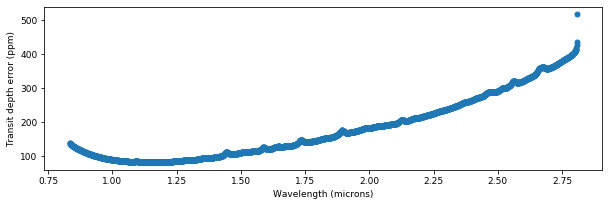

In [5]:
plt.figure(figsize=(10,3))
plt.plot(w_PandExo, deptherror_PandExo*1e6, 'o')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Transit depth error (ppm)')

And, finally, **(3) The total number of electrons in ($S_{in}$) and out ($S_{out}$) of transit, their variances ($\sigma^2_{S_{in}}$ and $\sigma^2_{S_{out}}$, respectively) and the number of integrations in ($N_{in}$) and out ($N_{out}$) of transit**: 

In [6]:
var_out, var_in = data['RawData']['var_out'], data['RawData']['var_in']
S_out, S_in = data['RawData']['electrons_out'], data['RawData']['electrons_in']
N_out, N_in = data['timing']['Num Integrations Out of Transit'], data['timing']['Num Integrations In Transit']

These latter ones are a bit redundant with the transit spectrum, because with these latter numbers one can actually obtain the same plot as above (i.e., the transit depth error as a function of wavelength). It is informative to understand why, so I'm going to explain it here --- but at the end of the day, I don't think it is imperative to understand the whole thing for our experiment. Still, you might find a ton of benefits understanding it, so here I go.

The estimator we astronomers use to get the transit depth, assuming a box-model for the transit, is $\hat{\delta} = 1 - \hat{F}_{in}/\hat{F}_{out}$, where:

$\hat{F}_{in} = \frac{\sum F^{in}_i}{N_{in}} = \hat{S}_{in}/N_{in}$

$\hat{F}_{out} = \frac{\sum F^{out}_j}{N_{out}} = \hat{S}_{out}/N_{out}$

So, basically, what we do is to get the average flux inside of the transit, $\hat{F}_{in}$, divide that by the flux out-of-transit, $\hat{F}_{out}$, and substract that to one --- that's how we estimate the transit depth $\hat{\delta} = 1 - \hat{F}_{in}/\hat{F}_{out}$ (remember, our estimate for the square of the planet-to-star radius ratio). Now, those averages themselves are computed the way averages are computed: just sum up the flux on those portions of the event, $\hat{S}_{in}$ and $\hat{S}_{out}$, and divide that by the total number of integrations, $N_{in}$ and $N_{out}$ respectively. 

Now --- how do we estimate the variance on our estimator $\hat{\delta}$, $\hat{\sigma}^2_{\hat{\delta}}$? The most common way is to use the <a href="https://www.itl.nist.gov/div898/handbook/mpc/section5/mpc55.htm">delta method</a>; in this case, this would be given by:

$\hat{\sigma}^2_{\hat{\delta}} = \left(\frac{\partial \hat{\delta}}{\partial \hat{S}_{in}}\right)^2 \hat{\sigma}^2_{\hat{S}_{in}} + \left(\frac{\partial \hat{\delta}}{\partial \hat{S}_{out}}\right)^2 \hat{\sigma}^2_{\hat{S}_{out}}$

Doing the partial derivatives, and applying some algebra, gives:

$\hat{\sigma}^2_{\hat{\delta}} = \left(\frac{N_{out}}{N_{in}}\frac{1}{\hat{S}_{out}}\right)^2 \hat{\sigma}^2_{\hat{S}_{in}} + \left(\frac{N_{out}}{N_{in}}\frac{\hat{S}_{in}}{\hat{S}_{out}^2}\right)\hat{\sigma}^2_{\hat{S}_{out}}$

It will come as no surprise that this is _exactly_ what <a href="https://github.com/natashabatalha/PandExo/blob/ae8ab46771305cad37d3d5a92d81ad89dca83d8f/pandexo/engine/jwst.py#L262">PandExo does to estimate the errors on the transit depth</a> (i.e., to generate the plot above). Let's in fact compare them:


Text(0, 0.5, 'Transit depth error (ppm)')

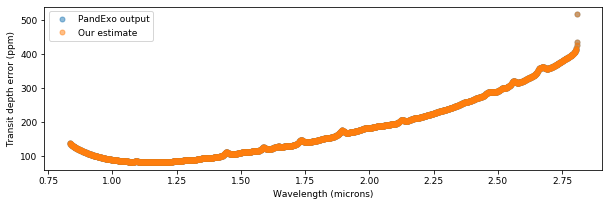

In [7]:
variance_delta = (((N_out / N_in) * (1. / S_out))**2) * var_in + \
                 (((N_out / N_in) * (S_in / S_out**2))**2) * var_out

plt.figure(figsize=(10,3))
plt.plot(w_PandExo, deptherror_PandExo*1e6, 'o',alpha=0.5,label='PandExo output')
plt.plot(w_PandExo, np.sqrt(variance_delta)*1e6, 'o',alpha=0.5,label='Our estimate')
plt.legend()

plt.xlabel('Wavelength (microns)')
plt.ylabel('Transit depth error (ppm)')

As expected, exactly the same values. 

### 2. Generating "real" transit lightcurves

#### 2.1 Obtaining the noise of our transit lightcurves

To generate our "real" transit lightcurves (i.e., with a "real" model), we are interested on computing the errorbars on each associated flux value. When we actually measure individual fluxes on a real JWST observation, what people will typically do would be to divide all the individual flux values by the average of the out-of-transit flux --- this will give you a _normalized_ transit lightcurve, in turn --- and it is the error on these normalized fluxes the one we are interested in computing.

So, we want the variance of $F^{out}_{j}/\hat{F}_{out}$. Instead of doing a delta-method calculation, here we will do a bit of an approximation, and assume that the variance on this term will be dominated by the variance on $F^{out}_{j}$. This makes sense because the average out-of-transit flux ($\hat{F}_{out} = S_{out}/N_{out}$) will be measured at exquisite precision. In turn, given PandExo gives us the error on the sum of the out-of-transit flux, we can compute the variance on $F^{out}_{j}$ by noting that:

$S_{out} = \sum F^{out}_{j} \rightarrow \sigma^2_{S_{out}} = N_{out}\sigma^2_{F^{out}_{j}}$.

So our final estimate for the variance of $F^{out}_{j}/\hat{F}_{out}$ is:

$\frac{\sigma^2_{\hat{S}_{out}} N_{out}}{\hat{S}^2_{out}}$

Let's plot this lightcurve precision as a function of wavelength:

Text(0, 0.5, 'Normalized flux error (ppm)')

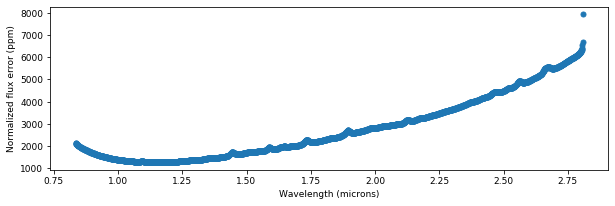

In [8]:
variance_Fj = (var_out * N_out)/(S_out**2)

plt.figure(figsize=(10,3))
plt.plot(w_PandExo, np.sqrt(variance_Fj)*1e6, 'o')

plt.xlabel('Wavelength (microns)')
plt.ylabel('Normalized flux error (ppm)')

Note the shapes are exactly the same as the ones for the transit depth errors. This makes sense: because PandExo uses a box-model for the transit, the transit depth errors are just a scaling of this curve. It is easy to show (see JWST-STScI-007586) that, assuming the number of out-of-transit points is the same as in-transit points and under the assumptions made here (i.e., that the average out-of-transit flux is calculated with extremely good precision), the error on the transit depth can be given by $\sigma \sqrt{2/N_{out}}$, where $\sigma$ is the lightcurve precision out-of-transit (i.e., the square-root of the variance we just calculated) and $N_{out}$ is the number of out-of-transit points. We can thus use this equation to get the same results as PandExo using the numbers above: there are 464 integrations out-of-transit ($N_{out} = 464$); let's compare this estimate with the outputs of PandExo:

Text(0.5, 0, 'Wavelength (microns)')

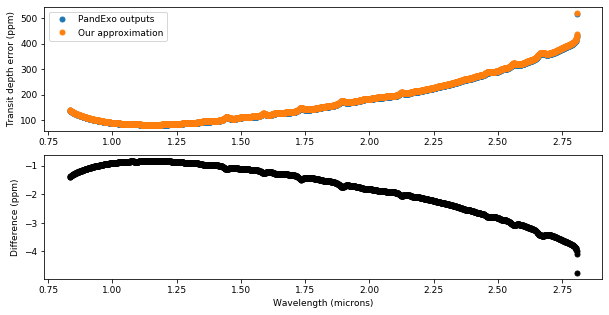

In [9]:
plt.figure(figsize=(10,5))

plt.subplot(211)
# PandExo outputs:
plt.plot(w_PandExo, deptherror_PandExo*1e6, 'o',label='PandExo outputs')

# Our estimate:
plt.plot(w_PandExo, (np.sqrt(variance_Fj) * np.sqrt(2./N_out))*1e6,'o', label='Our approximation')
plt.legend()
plt.ylabel('Transit depth error (ppm)')
plt.subplot(212)
plt.plot(w_PandExo, (deptherror_PandExo - (np.sqrt(variance_Fj) * np.sqrt(2./N_out)))*1e6, 'ko')
plt.ylabel('Difference (ppm)')

plt.xlabel('Wavelength (microns)')

Nice! Precision is almost spot-on. The maximum difference between our approximation and the PandExo output is 4 ppm in this case, which is _way_ smaller than the transit depth precision --- so _extremely_ good approximation. We are then happy with these approximations for the lightcurve errors.

#### 2.2 Generating transit lightcurve models

Now that we have errorbars for each wavelength, we are ready to generate our transit lightcurves! To this end, we need to understand the parameters we'll be interested in varying in this experiment: these are the limb-darkening coefficients, $u_1$ and $u_2$, and the inclination of the orbit, $i$. The limb-darkening coefficients basically define the shape of the lightcurve (no limb-darkening means the model is actually pretty close to a box model). We've taken limb-darkening coefficients from SOSS from ExoCTK --- let's load them and interpolate them here:

In [10]:
wld,u1,u2 = np.loadtxt('data/lds_order1.txt',unpack=True)
f1 = interp1d(wld,u1)
f2 = interp1d(wld,u2)

Now we need to define the parameters that will define the lightcurve for HAT-P-1b, including the inclination $i$ (which we will want to vary in our experiments). Let's define the planet properties as the ones from Exo.MAST (https://exo.mast.stsci.edu/exomast_planet.html?planet=HATP1b; note PandExo also retrieves properties from Exo.MAST):

In [11]:
P, a, inc, ecc, omega, rp = 4.4652998, 10.22, 85.79, 0., 90., 0.116

All right, now, using all that information and a set of times, the following function returns a transit lightcurve centered around time $t_0 = 0$:

In [12]:
def transit_model(t, inc, w):
    """
    Given a time array t, an inclination "inc" and a wavelength in microns "w", this function returns 
    a lightcurve model including limb-darkening.
    """
    params = batman.TransitParams()
    params.t0 = 0. # time of inferior conjunction
    params.per = P # orbital period (days)
    params.a = a # semi-major axis (in units of stellar radii)
    params.rp = rp
    params.inc = inc # orbital inclination (in degrees)
    params.ecc = ecc # eccentricity
    params.w = omega # longitude of periastron (in degrees) p
    params.limb_dark = 'quadratic' # limb darkening profile to use
    if w<np.min(wld):
        c1,c2 = f1(np.min(wld)),f2(np.min(wld))
    elif w>np.max(wld):
        c1,c2 = f1(np.max(wld)),f2(np.max(wld))
    else:
        c1,c2 = f1(w), f2(w)
    
    params.u = [c1,c2] # limb darkening coefficients

    tmodel = batman.TransitModel(params, t.astype('float64'))
    return tmodel.light_curve(params)

Okay; let's test this! We first need to define the time-array. To this end, note the PandExo simulations above spend 928 total integrations on the target, with the same amount of time in and out-of-transit. So we can just sample 928 points in our time-array, centered around 0. What's the difference between each time-stamp? The time per integration --- `data['timing']['Time/Integration incl reset (sec)']`, which is 22.14 seconds. Let's create this time-array:

In [13]:
# First, create an array that goes from zero to 927. Multiply that by the time per integration (in days):
time_per_int = data['timing']['Time/Integration incl reset (sec)']/(3600.*24.)
nintegrations = data['timing']['APT: Num Integrations per Occultation']
t = np.arange(nintegrations) * time_per_int

# Now, if nintegrations is even, substract the mean between elements (nintegrations/2) and  (nintegrations/2)+1. 
# If odd, substract np.floor(nintegrations/2):
if nintegrations % 2 == 0:
    middle_mean = (t[int(nintegrations/2)] + t[int(nintegrations/2) + 1])*0.5
else:
    middle_mean = t[int(np.floor(nintegrations/2))]
t = t - middle_mean

Now generate a model for the smallest and largest wavelength in the `w_PandExo` array:

In [14]:
model_lowest = transit_model(t, inc, w_PandExo[0])
model_highest = transit_model(t, inc, w_PandExo[-1])

Plot them:

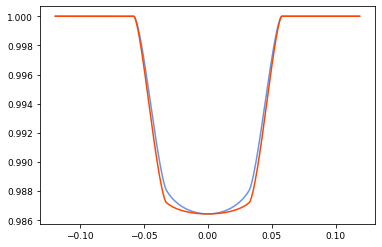

In [15]:
plt.plot(t, model_lowest, color='cornflowerblue')
plt.plot(t, model_highest, color='orangered')

Nice! As expected, the highest wavelength shows a much more "box-shaped" lightcurve than the lowest wavelength bin. Let's add some noise now --- to this end, let's use the `variance_Fj` we estimated above:

In [16]:
lightcurve_errors = np.sqrt(variance_Fj)

# Noise for the lowest wavelength bin:
noise_lowest = np.random.normal(0., lightcurve_errors[0], len(t))


# Same for the highest wavelength bin:
noise_highest = np.random.normal(0., lightcurve_errors[-1], len(t))

Let's plot them:

(-0.13, 0.13)

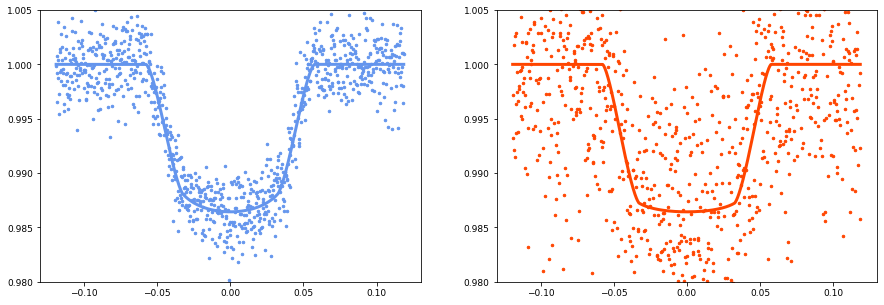

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(121)
# Plot simulated data, along with the model for the lowest wavelength bin:
plt.plot(t, model_lowest + noise_lowest, '.', color='cornflowerblue')
plt.plot(t, model_lowest, color='cornflowerblue', lw = 3)
plt.ylim(0.980,1.005)
plt.xlim(-0.13,0.13)

plt.subplot(122)
# Same for the higher wavelength bin:
plt.plot(t, model_highest + noise_highest, '.', color='orangered')
plt.plot(t, model_highest, color='orangered', lw = 3)
plt.ylim(0.980,1.005)
plt.xlim(-0.13,0.13)

All right! That's pretty neat --- that's how we generate noisy transit lightcurves.

Our next job: fit them using `juliet`!

### 3 Fitting "real" transit lightcurves

Above we generated some "real" transit lightcurves for two different wavelength bins. Let's fit them with `juliet`! To this end, we'll do a fit with the limb-darkening coefficients left as free parameters, and with those held fixed.

#### 3.1. Fits with limb-darkening coefficients as free parameters

Let's fit these simulated lightcurves with the limb-darkening coefficients left as free parameters. `juliet` uses a special parametrization to fit these which allows to efficiently explore the whole parameter space; so it doesn't fit `u_1` and `u_2` directly, but fits for `q_1` and `q_2` which are transformations of those parameters. Also, `juliet` doesn't fit for the inclination --- it fits for the impact parameter, which is given by $b = (a/R_*)\cos i$ in our case (we do this transformation below). In addition, `juliet` also allows to fit for the out-of-transit fluxes (`mflux_SOSS` below). PandExo also accounts for this uncertainty, so we fit for it as well. Everything else is assumed perfectly known.

Let's thus define the priors for this fit; let's first fit the bluer lightcurve (i.e., the one with the lowest wavelength value):

In [18]:
# Name of the parameters to be fit:
params = ['P_p1','t0_p1','p_p1','b_p1','q1_SOSS','q2_SOSS','ecc_p1','omega_p1',\
              'a_p1', 'mdilution_SOSS', 'mflux_SOSS', 'sigma_w_SOSS']

# Distributions:
dists = ['fixed','fixed','uniform','fixed','uniform','uniform','fixed','fixed',\
                 'fixed', 'fixed', 'normal', 'fixed']

# Hyperparameters
hyperps = [P, 0., [0.,1], a*np.cos(inc*np.pi/180.), [0., 1.], [0., 1.], ecc, omega,\
                   a, 1.0, [0.,0.1], 1e-6]

priors = juliet.generate_priors(params,dists,hyperps)

Let's define the dataset in the `juliet` format:

In [19]:
# Create dictionaries for the times; note for the errors on the fluxes, we assume they are all the same:
times, fluxes, fluxes_error = {}, {}, {}
times['SOSS'], fluxes['SOSS'], fluxes_error['SOSS'] = t, model_lowest + noise_lowest, \
                                                      np.ones(len(t))*lightcurve_errors[0]

# Load the dataset 
dataset_lowest = juliet.load(priors=priors, t_lc = times, y_lc = fluxes,\
                             yerr_lc = fluxes_error, out_folder = 'lowest_wavelength_results')

And...fit! Note that if using `dynesty`, this fit can take like 5-10 mins. With `MultiNest` --- takes less than a minute. This is why `MultiNest` is recommended to be installed!

In [20]:
results_lowest = dataset_lowest.fit()

Let's see how good the fit was to the data:

In [21]:
modelfit_lowest = results_lowest.lc.evaluate('SOSS')

(-0.13, 0.13)

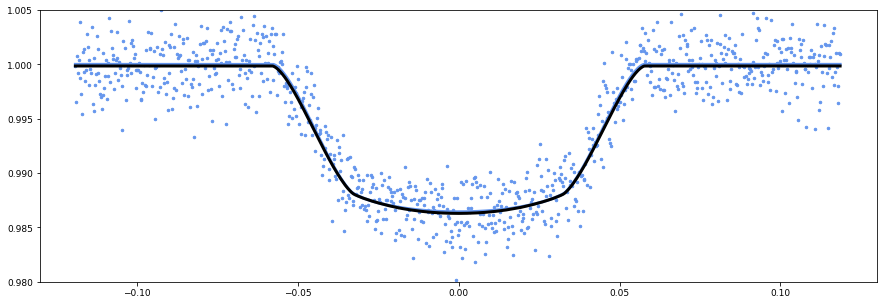

In [23]:
plt.figure(figsize=(15,5))

# Plot simulated data, along with the real model and the fitted model:
plt.plot(t, model_lowest + noise_lowest, '.', color='cornflowerblue')
plt.plot(t, model_lowest, color='cornflowerblue', lw = 3,label='Real model')
plt.plot(t, modelfit_lowest, color='black', lw = 3,label='Fitted model')
plt.ylim(0.980,1.005)
plt.xlim(-0.13,0.13)

Pretty good! Almost indistinguishable. Now --- what is the error on the transit depth of this model, and how does it compare to the PandExo estimate? Remember that `juliet` fits for the planet-to-star radius ratio --- `p_p1`. The square of that gives us the transit depth. We can extract `p_p1`'s posterior distribution as follows from the `juliet` results:

In [24]:
p = results_lowest.posteriors['posterior_samples']['p_p1']

Again, this gives us a _distribution_. We can take the mean, the standard deviation, etc. of this distribution. Let's take the standard deviation, and compare that to the one estimated by PandExo:

In [25]:
# Estimate from our fit:
depth = p**2
error_on_depth = np.sqrt(np.var(depth))
print('Error on transit depth:',np.round(error_on_depth*1e6,1), 'ppm')
# Estimate from PandExo:
print('Error on transit depth from PandExo:',np.round(deptherror_PandExo[0]*1e6,1),'ppm')

Error on transit depth: 377.0 ppm
Error on transit depth from PandExo: 139.3 ppm


Wow! That's almost a factor of 3 difference --- with the "real" error being much larger. Now, I have to note that this "error on the transit depth" actually has an associated _error_ to itself. We'll deal with that later in the project; for now, that number is pretty informative.

**What about the same fit for the highest wavelength range?** Let's use the exact same priors, but let's just change the dataset:

In [26]:
# Create dictionaries for the times; note for the errors on the fluxes, we assume they are all the same:
times, fluxes, fluxes_error = {}, {}, {}
times['SOSS'], fluxes['SOSS'], fluxes_error['SOSS'] = t, model_highest + noise_highest, \
                                                      np.ones(len(t))*lightcurve_errors[-1]

# Load the dataset 
dataset_highest = juliet.load(priors=priors, t_lc = times, y_lc = fluxes,\
                             yerr_lc = fluxes_error, out_folder = 'highest_wavelength_results')

In [27]:
results_highest = dataset_highest.fit()

All right; let's evaluate this one as well to see how well our fit went:

In [28]:
modelfit_highest = results_highest.lc.evaluate('SOSS')

(-0.13, 0.13)

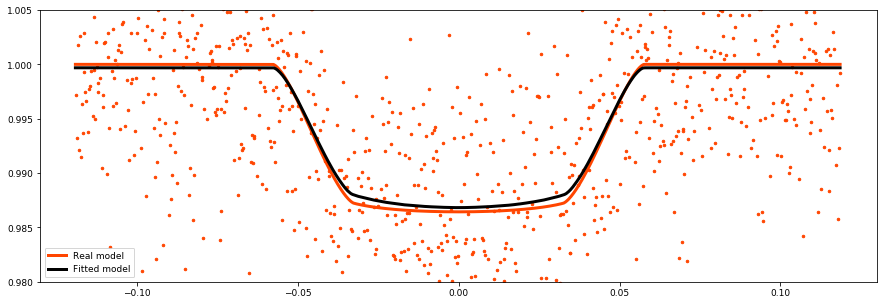

In [29]:
plt.figure(figsize=(15,5))

# Plot simulated data, along with the real model and the fitted model:
plt.plot(t, model_highest + noise_highest, '.', color='orangered')
plt.plot(t, model_highest, color='orangered', lw = 3,label='Real model')
plt.plot(t, modelfit_highest, color='black', lw = 3,label='Fitted model')
plt.legend()
plt.ylim(0.980,1.005)
plt.xlim(-0.13,0.13)

Okay, fit was not as good as for the bluer wavelengths. This makes sense --- data is much noisier! Let's compare the estimates on the errors:

In [30]:
p = results_highest.posteriors['posterior_samples']['p_p1']

In [31]:
# Estimate from our fit:
depth = p**2
error_on_depth = np.sqrt(np.var(depth))
print('Error on transit depth:',np.round(error_on_depth*1e6,1), 'ppm')
# Estimate from PandExo:
print('Error on transit depth from PandExo:',np.round(deptherror_PandExo[-1]*1e6,1),'ppm')

Error on transit depth: 697.7 ppm
Error on transit depth from PandExo: 516.3 ppm


All right --- it seems that the error on the transit depth from a fit with a real transit lightcurve is indeed larger, but the change is not as dramatic as it was for the bluer wavelength bins; only a factor of $\sim 30\%$ larger. Not that bad for a box-shaped model! So it seems that the prediction would be that for the bluer wavelengths, the "real" lightcurve model is indeed needed to get realistic errorbars, whereas for redder wavelengths the error using a box-model is not such a bad estimate. That confirms our intuition!

#### 3.2. Fits with fixed limb-darkening coefficients 

In `juliet` one can also fix the limb-darkening coefficients. However, one first has to convert the $u_1$ and $u_2$ coefficients to the $q_1$, $q_2$ plane. `juliet` has some utility functions to do this; let's create a function that, similarly to the lightcurve generating function above, given a wavelength it returns the corresponding $q_1$ and $q_2$ coefficients:

In [32]:
def generate_q(w):
    if w<np.min(wld):
        c1,c2 = f1(np.min(wld)),f2(np.min(wld))
    elif w>np.max(wld):
        c1,c2 = f1(np.max(wld)),f2(np.max(wld))
    else:
        c1,c2 = f1(w), f2(w)
    return juliet.utils.reverse_q_coeffs('quadratic',c1, c2)

Let's use this function to perform a fit to the lowest wavelength bins **fixing** the limb-darkening coefficients:

In [33]:
q1_lowest, q2_lowest = generate_q(w_PandExo[0])

In [34]:
# Name of the parameters to be fit:
params = ['P_p1','t0_p1','p_p1','b_p1','q1_SOSS','q2_SOSS','ecc_p1','omega_p1',\
              'a_p1', 'mdilution_SOSS', 'mflux_SOSS', 'sigma_w_SOSS']

# Distributions:
dists = ['fixed','fixed','uniform','fixed','fixed','fixed','fixed','fixed',\
                 'fixed', 'fixed', 'normal', 'fixed']

# Hyperparameters
hyperps = [P, 0., [0.,1], a*np.cos(inc*np.pi/180.), q1_lowest, q2_lowest, ecc, omega,\
                   a, 1.0, [0.,0.1], 1e-6]

priors = juliet.generate_priors(params,dists,hyperps)

In [35]:
# Create dictionaries for the times; note for the errors on the fluxes, we assume they are all the same:
times, fluxes, fluxes_error = {}, {}, {}
times['SOSS'], fluxes['SOSS'], fluxes_error['SOSS'] = t, model_lowest + noise_lowest, \
                                                      np.ones(len(t))*lightcurve_errors[0]

# Load the dataset 
dataset_lowest = juliet.load(priors=priors, t_lc = times, y_lc = fluxes,\
                             yerr_lc = fluxes_error, out_folder = 'lowest_wavelength_results-fixedLDS')

In [36]:
results_lowest = dataset_lowest.fit()

Let's once again compare results with the real, underlying model:

In [37]:
modelfit_lowest = results_lowest.lc.evaluate('SOSS')

(-0.13, 0.13)

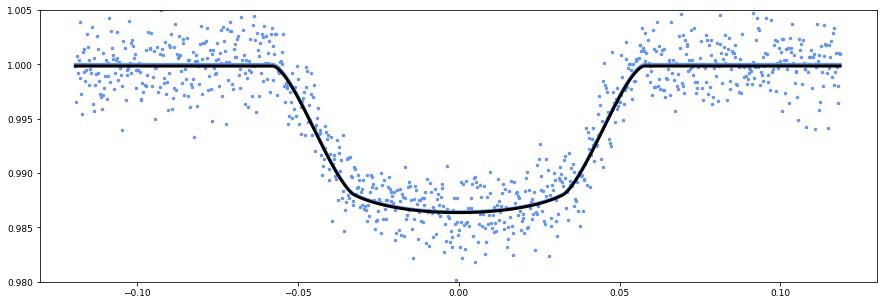

In [39]:
plt.figure(figsize=(15,5))

# Plot simulated data, along with the real model and the fitted model:
plt.plot(t, model_lowest + noise_lowest, '.', color='cornflowerblue')
plt.plot(t, model_lowest, color='cornflowerblue', lw = 3,label='Real model')
plt.plot(t, modelfit_lowest, color='black', lw = 3,label='Fitted model')
plt.ylim(0.980,1.005)
plt.xlim(-0.13,0.13)

Again, pretty good! Let's compare errors on the transit depths with those of PandExo:

In [40]:
p = results_lowest.posteriors['posterior_samples']['p_p1']

In [41]:
# Estimate from our fit:
depth = p**2
error_on_depth = np.sqrt(np.var(depth))
print('Error on transit depth:',np.round(error_on_depth*1e6,1), 'ppm')
# Estimate from PandExo:
print('Error on transit depth from PandExo:',np.round(deptherror_PandExo[0]*1e6,1),'ppm')

Error on transit depth: 165.0 ppm
Error on transit depth from PandExo: 139.3 ppm


Hey --- that seems much better! That's only a 18\% difference with the box-model estimate. This is very interesting; basically, this shows that if we _trust_ the limb-darkening coefficients and fix them, we can get errors pretty close to those estimated with the box model. So it seems uncertainty on the limb-darkening coefficients is really important to pinpoint (in reality --- we have no idea if our model limb-darkening coefficients will be good enough for JWST-like precisions or not. That's a different story!). Do we obtain similar results with the reddest wavelenghts? Let's fit those lightcurves in a similar fashion. First, extract transformed limb-darkening coefficients:

In [42]:
q1_highest, q2_highest = generate_q(w_PandExo[-1])

And, fit the dataset:

In [43]:
# Name of the parameters to be fit:
params = ['P_p1','t0_p1','p_p1','b_p1','q1_SOSS','q2_SOSS','ecc_p1','omega_p1',\
              'a_p1', 'mdilution_SOSS', 'mflux_SOSS', 'sigma_w_SOSS']

# Distributions:
dists = ['fixed','fixed','uniform','fixed','fixed','fixed','fixed','fixed',\
                 'fixed', 'fixed', 'normal', 'fixed']

# Hyperparameters
hyperps = [P, 0., [0.,1], a*np.cos(inc*np.pi/180.), q1_highest, q2_highest, ecc, omega,\
                   a, 1.0, [0.,0.1], 1e-6]

priors = juliet.generate_priors(params,dists,hyperps)

In [44]:
# Create dictionaries for the times; note for the errors on the fluxes, we assume they are all the same:
times, fluxes, fluxes_error = {}, {}, {}
times['SOSS'], fluxes['SOSS'], fluxes_error['SOSS'] = t, model_highest + noise_highest, \
                                                      np.ones(len(t))*lightcurve_errors[-1]

# Load the dataset 
dataset_highest = juliet.load(priors=priors, t_lc = times, y_lc = fluxes,\
                             yerr_lc = fluxes_error, out_folder = 'highest_wavelength_results-fixedLDS')

In [45]:
results_highest = dataset_highest.fit()

Compare the fits:

In [46]:
modelfit_highest = results_highest.lc.evaluate('SOSS')

(-0.13, 0.13)

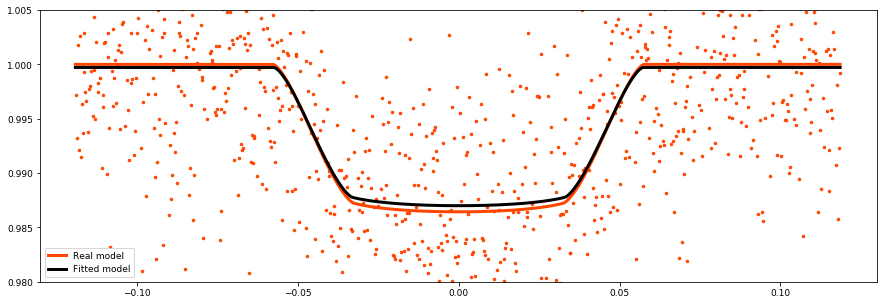

In [47]:
plt.figure(figsize=(15,5))

# Plot simulated data, along with the real model and the fitted model:
plt.plot(t, model_highest + noise_highest, '.', color='orangered')
plt.plot(t, model_highest, color='orangered', lw = 3,label='Real model')
plt.plot(t, modelfit_highest, color='black', lw = 3,label='Fitted model')
plt.legend()
plt.ylim(0.980,1.005)
plt.xlim(-0.13,0.13)

Still some uncertainty, but visibly much better at least in the lightcurve shapes! What about errors on the transit depths?

In [48]:
p = results_highest.posteriors['posterior_samples']['p_p1']

In [49]:
# Estimate from our fit:
depth = p**2
error_on_depth = np.sqrt(np.var(depth))
print('Error on transit depth:',np.round(error_on_depth*1e6,1), 'ppm')
# Estimate from PandExo:
print('Error on transit depth from PandExo:',np.round(deptherror_PandExo[-1]*1e6,1),'ppm')

Error on transit depth: 591.9 ppm
Error on transit depth from PandExo: 516.3 ppm


Only a 14\% difference. So indeed, it seems fixing the limb-darkening coefficients helps the cause.

### 3. Conclusions of this notebook & work to do

It seems that if we assume fixed limb-darkening coefficients, the box-model PandExo assumes is close enough to the "truth" in the two wavelength bins we tried our experiment on. However, we need to see how this behavior tracks over the entire wavelength range to truly conclude this. We also haven't explored varying the inclinations; and we also need to, at the end, do the experiments with the limb-darkening coefficients left as free parameters.

In summary, we need to:
1. Perform the same fits presented above in all wavelengths assuming both fixed and free limb-darkening coefficients. Plot errors on the transit depth versus wavelength and compare them to the PandExo estimates. I recommend starting with the fits using fixed limb-darkening coefficients.


2. Do the same experiments with different inclinations. I propose to do the experiments for inc = 85.79 (which is the actual value for HAT-P-1b; the one we used here), inc = 84.9 (which gives a "grazing" transit, i.e., a transit right at the edge) and inc = 90 (i.e., a central transit --- best-case scenario). 

_Happy fitting_!